<h1 style="color:red; text-align:center; font-weight:bold"> Amazon Reviews Classification </h1>

<h3 style="color:green"> Prepare the environment: </h3>

First, we should prepare the environment, by running `findspark.init()`, we make it possible to use the PySpark API, which is the Python API for Spark, and access Spark's distributed computing capabilities from within your Python environment.

In [1]:
import findspark
findspark.init()

Let's import necessary modules and classes.

In [2]:
import pandas as pd
import numpy as np
import functools
import os
import re
from matplotlib import pyplot as plt

import pyspark
from pyspark import SparkContext

from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.functions import input_file_name, lit
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.functions import shuffle, rand, col, sum
from pyspark.sql.functions import pandas_udf

from pyspark.sql.types import StringType, StructField, StructType
from pyspark.sql.types import IntegerType, ArrayType, FloatType

from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

from pyspark.ml.feature import HashingTF, Tokenizer, StopWordsRemover
from pyspark.ml.feature import Tokenizer, Word2Vec, VectorIndexer
from pyspark.ml.feature import IndexToString, StringIndexer, VectorAssembler

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.mllib.evaluation import BinaryClassificationMetrics

%matplotlib inline

Create a SparkSession object, with some special configuration that we'll need later. 

In [4]:
spark = SparkSession.builder \
    .appName("Project 2") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

sqlContext = SQLContext(spark)

C:\spark\spark-3.3.1-bin-hadoop2\python\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Initializing the data paths

In [6]:
movies_path = "Movies_and_TV.json"
meta_path = "meta_Movies_and_TV.json"

<h3 style="color:green"> Import Data: </h3>

Our data is a __json__ file, in this section we'll read the data, print the dataframe schema, and then take a look on the data

In [7]:
df = spark.read.json(movies_path)

df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Shape:: string (nullable = true)
 |    |-- Size:: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- verified: boolean (nullable = true)
 |-- vote: string (nullable = true)



It looks like we have some sup-columns, let's split the '`style`' and '`image`' columns into individual columns.

In [8]:
df = df.select(
    col("asin"),
    col("image"),
    col("image").getItem(0).alias("element"),
    col("overall"),
    col("reviewText"),
    col("reviewTime"),
    col("reviewerID"),
    col("reviewerName"),
    col("style").getField("Color:").alias("color"),
    col("style").getField("Format:").alias("format"),
    col("style").getField("Shape:").alias("shape"),
    col("style").getField("Size:").alias("size"),
    col("summary"),
    col("unixReviewTime"),
    col("verified"),
    col("vote")
)

df.show()

+----------+-----+-------+-------+--------------------+-----------+--------------+--------------------+-----+-------------+-----+----+--------------------+--------------+--------+----+
|      asin|image|element|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|color|       format|shape|size|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+-------+--------------------+-----------+--------------+--------------------+-----+-------------+-----+----+--------------------+--------------+--------+----+
|0001527665| null|   null|    5.0|really happy they...|03 11, 2013|A3478QRKQDOPQ2|               jacki| null|     VHS Tape| null|null|               great|    1362960000|    true|null|
|0001527665| null|   null|    5.0|Having lived in W...|02 18, 2013|A2VHSG6TZHU1OB|               Ken P| null| Amazon Video| null|null|Realistic and Acc...|    1361145600|    true|   3|
|0001527665| null|   null|    5.0|Excellent look in...|01 17, 2013|A23EJWOW

Since we have reviews classification, from now we'll use just the `overall` column (the target), and the `reviewText` column (input)

In [11]:
data = df.select("overall", "reviewText")

data.show()

+-------+--------------------+
|overall|          reviewText|
+-------+--------------------+
|    5.0|really happy they...|
|    5.0|Having lived in W...|
|    5.0|Excellent look in...|
|    5.0|More than anythin...|
|    4.0|This is a great m...|
|    5.0|This movie was in...|
|    5.0|This is a fascina...|
|    1.0|This DVD appears ...|
|    1.0|This movie is not...|
|    5.0|So sorry I didn't...|
|    5.0|Product received ...|
|    5.0|Believe me when I...|
|    5.0|This video arrive...|
|    5.0|The Reunion of th...|
|    5.0|Wedding Music (3:...|
|    5.0|This is truly a m...|
|    4.0|It is an excellen...|
|    5.0|I have a thing ag...|
|    5.0|This DVD is unbel...|
|    5.0|Just brought this...|
+-------+--------------------+
only showing top 20 rows



Let's now read the second json file.

In [10]:
df2 = spark.read.json(meta_path)

df2.printSchema()

root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- also_view: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: string (nullable = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: struct (nullable = true)
 |    |-- \n    Item Weight: \n    : string (nullable = true)
 |    |-- \n    Package Dimensions: \n    : string (nullable = true)
 |    |-- \n    Product Dimensions: \n    : string (nullable = true)
 |    |-- ASIN:: string (nullable = true)
 |    |-- ASIN: : string (nullable = true)
 |    |-- Audio CD: string (nullable = true)
 |    |-- Audio Description:: string (nullable = true)
 |    |-- Blu-ray Audio: string (nullable = true)
 |    |-- DVD Audio: string (nullable = true)
 |    |-- Digi

It looks like this file contains just some informations about the 'movies', we don't need this data rigth now.

We need to know more about the data, the `describe` method will display a summary about our data

In [12]:
data.describe().show()

+-------+------------------+--------------------+
|summary|           overall|          reviewText|
+-------+------------------+--------------------+
|  count|           8765568|             8757545|
|   mean|4.2330105704501975|1.598661428074902...|
| stddev|1.2214384170934065|3.876540716161416E20|
|    min|               1.0|                  \n|
|    max|               5.0|great show! I th...|
+-------+------------------+--------------------+



As we can see, there is some null values in the `reviewText`, let's count how much nulls we have:

In [13]:
null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])

null_counts.show()

+-------+----------+
|overall|reviewText|
+-------+----------+
|      0|      8023|
+-------+----------+



There is `8023` null values we should dealing with. We'll apply the simplest approach: remove all those rows with null values:

In [14]:
data = data.na.drop()

null_counts = data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns])

null_counts.show()

+-------+----------+
|overall|reviewText|
+-------+----------+
|      0|         0|
+-------+----------+



Well done!

Let's now move to the `overall` column, it represent the target of the model. First think to do is to check number of classes:

In [15]:
data.registerTempTable('reviews')
sqlContext\
    .sql("select overall, count(overall) as reviewCount from reviews group by overall order by overall desc")\
        .show()

C:\spark\spark-3.3.1-bin-hadoop2\python\pyspark\sql\dataframe.py:229: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


+-------+-----------+
|overall|reviewCount|
+-------+-----------+
|    5.0|    5485404|
|    4.0|    1496901|
|    3.0|     735630|
|    2.0|     406753|
|    1.0|     632857|
+-------+-----------+



From now, instead of using 5 classes, we'll just use 3:
  - class `1` for reviews with rating (overall) > 3, this class will represente the __positive__ reviews.
  - class `0` for reviews with rating = 3, this class will represente the __neutral__ reviews.
  - and the `-1` class, the __negatif__ class, it's the reviews with rating < 3.

In [16]:
udf = UserDefinedFunction(
    lambda x: 1 if x > 3.0 
    else 0 if x==3 
    else -1, 
    IntegerType()
)

data = data.withColumn("overall_recode", udf(data.overall))

In [17]:
review_counts = data.groupBy('overall_recode').count().orderBy('overall_recode')
review_counts.show()

+--------------+-------+
|overall_recode|  count|
+--------------+-------+
|            -1|1039610|
|             0| 735630|
|             1|6982305|
+--------------+-------+



Let's generate a bar plot to visualize the distribution of counts for each unique value in the '`overall_recode`' column.

([<matplotlib.axis.XTick at 0x23b6fa39660>,
 [Text(0, 0, '-1'), Text(1, 0, '1'), Text(2, 0, '0')])

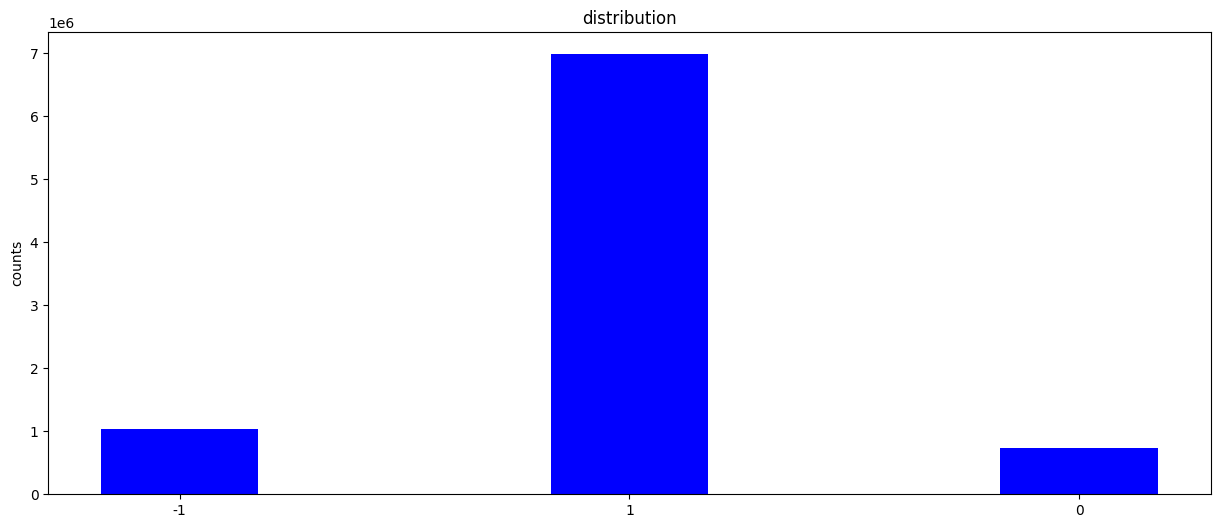

In [16]:
plt.rcParams['figure.figsize'] = (15, 6)
 
statuses = data.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]
 
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind, counts, width=width, color='b')
 
plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind, categories)

<h3 style="color:green"> Process Data <h3>

The dataset has almost 10 millions of rows, this number is too big to handle with, with our computers, so we'll use just 1 million rows:

In [20]:
data_1M = data.limit(1000000)

For this task we need the numerical representation of each word in each row, so that's what we'll do:

```shell
  Tokenizer   -->   StopWordsRemover   -->   Word2Vec
      |                     |                    |
 convert data      remove stopwords        generate word
  to tokens                                embedding of
                                            each word
```

For that, we'll create a __Tokenizer__ object named _tokenizer_ with the input column "reviewText" and the output column named "words".

Create a __StopWordsRemover__ object named _stopwords\_remover_ with the input column set to the output column of the _tokenizer_ object and the output column named "filtered_words".

Create a __Word2Vec__ object named _word2Vec_ with the input column set to the output column of the _stopwords\_remover_ object and the output column named "features".

```
           |
           | inputCol: reviewText
           |

       Tokenizer    

           |
           | outputCol: words
           |

   StopWordsRemover 

           |
           | outputCol: filtered_words
           |

       Word2Vec   

           |
           | outputCol: features
           |

In [21]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
stopwords_remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered_words")
word2vec = Word2Vec(vectorSize=300, seed=42, inputCol=stopwords_remover.getOutputCol(), outputCol="features")

Apply the functions to the data:

In [22]:
toknezed_data = tokenizer.transform(data_1M)
filtered_data = stopwords_remover.transform(toknezed_data)
final_data = word2vec.fit(filtered_data).transform(filtered_data)

Now, after processing the data, we'll split the data to training dataset and test dataset:

In [23]:
(trainingData, testData) = final_data.randomSplit([0.8, 0.2], seed=42)

<h3 style="color:green"> Build the Model <h3>

Define the stages for the Pipeline: first the target column "`overall_recode`" is _indexed_ to prepare it for classification. The indexed features are further processed using a _VectorIndexer_, which assigns indices to categorical features. The indexed features are _assembled_ into a single feature vector. Finally, the pipeline applies a chosen _classifier_ (__LogisticRegression__, __RandomForestClassifier__) to train the model and make predictions on the target variable.

In [24]:
label_indexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel")
feature_indexer = VectorIndexer(inputCol=word2vec.getOutputCol(), outputCol="indexedFeatures", maxCategories=5)
assembler = VectorAssembler(inputCols=[feature_indexer.getOutputCol()], outputCol="feature_vector")

classifiers = [
    LogisticRegression(labelCol="indexedLabel", featuresCol="feature_vector"),
    RandomForestClassifier(labelCol="indexedLabel", featuresCol="feature_vector")
]

```
           |
           | inputCol: features
           |

     StringIndexer  

           |
           | outputCol: indexedLabel
           |

    VectorIndexer 

           |
           | outputCol: indexedFeatures
           |

     VectorAssembler 

           |
           | outputCol: feature_vector
           |

      Classifier  

Final thing to do before training the model is to define the evaluator, in our case we'll use a __Multiclass Classification Evaluator__

In [25]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", 
    predictionCol="prediction", 
    metricName="accuracy"
    )

<h3 style="color:green"> Train and evaluate <h3>

In [26]:
results = []

for i, classifier in enumerate(classifiers):
    pipeline = Pipeline(stages=[
        label_indexer, 
        feature_indexer,
        assembler, 
        classifier
        ]
    )
    
    model = pipeline.fit(trainingData)
    predictions = model.transform(testData)

    accuracy = evaluator.evaluate(predictions)
    results.append((classifier.__class__.__name__, accuracy))

In [27]:
results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
print(results_df)

                    Model  Accuracy
0      LogisticRegression  0.864901
1  RandomForestClassifier  0.833479


Well done, both the logistic regression and the random forest give good and close values.

In [28]:
# Close SparkSession
spark.stop()